## Importing libraries

In [7]:
from sentenceSegmentation import SentenceSegmentation
from tokenization import Tokenization
from inflectionReduction import InflectionReduction
from stopwordRemoval import StopwordRemoval
from informationRetrieval import InformationRetrieval
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

from sys import version_info
# import argparse
import json
import time
import matplotlib.pyplot as plt
from util import *
# from main import SearchEngine
from evaluation import Evaluation

import warnings
warnings.filterwarnings("ignore")

## Data importing and pre-processing

In [8]:
# Read queries
queries_json = json.load(open( ".\cranfield\cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], \
                        [item["query"] for item in queries_json]

# Read documents
docs_json = json.load(open(".\cranfield\cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], \
                        [item["body"] for item in docs_json]
# Loading preprocessed queries
Preprocessed_queries = json.load(open('.\output\stopword_removed_queries.txt', 'r'))
# Loading Preprocessed docs
Preprocessed_docs = json.load(open('.\output\stopword_removed_docs.txt', 'r'))

qrels = json.load(open( "./cranfield/cran_qrels.json", 'r'))[:]



## Helper functions

In [42]:
# works for docs only
def TF_IDF(docs, doc_ids, word_map, normalize = True, is_queries= False):
    """
    docs : list of list of lists
    is_queries : True if we are passing queries
    return :: tf_idf representation of documents (numpy array)
    """
    m = len(set(word_map))  # number of words
    n = len(doc_ids)       # number of docs
    
    tf = np.zeros((m,n)) # initialising
    # filling the tf vector part
    for i in range(n):
        for sent in docs[i]:
            for word in sent:
                try:
                    tf[word_map[word]][doc_ids[i]-1] += 1
                except:
                    #print(word)
                    pass
    
    idf = tf!=0
    idf = np.sum(idf, axis = 1)
    idf = np.log10(n/idf).reshape(-1,1)
    tf_idf = idf*tf
    if(is_queries):
        tf_idf = tf
    if (normalize):
        epsilon = 1e-4
        return tf_idf/ (np.linalg.norm(tf_idf, axis = 0)+epsilon)
    
    return tf_idf

In [11]:
# Reference
evaluator = Evaluation()
def Evaluation_metrics(doc_IDs_ordered, query_ids, qrels, n_comp, op_folder = './',save_results = 2, verbose = 1):
    """
    save_results : 0    ===> don't save anything
                 : 1    ===> just save results
                 : > 2  ===> save plots also
    """
    precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []
    for k in range(1,11):
        precision = evaluator.meanPrecision(
            doc_IDs_ordered, query_ids, qrels, k)
        precisions.append(precision)
        recall = evaluator.meanRecall(
            doc_IDs_ordered, query_ids, qrels, k)
        recalls.append(recall)
        fscore = evaluator.meanFscore(
            doc_IDs_ordered, query_ids, qrels, k)
        fscores.append(fscore)

        MAP = evaluator.meanAveragePrecision(
            doc_IDs_ordered, query_ids, qrels, k)
        MAPs.append(MAP)
        nDCG = evaluator.meanNDCG(
            doc_IDs_ordered, query_ids, qrels, k)
        nDCGs.append(nDCG)
        if (verbose):
            print("Precision, Recall and F-score @ " +  
                str(k) + " : " + str(precision) + ", " + str(recall) + 
                ", " + str(fscore))
            print("MAP, nDCG @ " +  
                str(k) + " : " + str(MAP) + ", " + str(nDCG))
        if (save_results > 0):
        # saving the results
            with open(op_folder+'Results/LSA_'+str(n_comp)+'.txt', 'a') as f:
                f.write(str(k) + " , " + str(precision) + ", " + str(recall) + 
                        ", " + str(fscore)+", "+str(MAP) + ", " + str(nDCG)+'\n')
            with open(op_folder+'Results/metrics_'+str(k)+'.txt', 'a') as f:
                f.write(str(n_comp) + " , " + str(precision) + ", " + str(recall) + 
                        ", " + str(fscore)+", "+str(MAP) + ", " + str(nDCG)+'\n')
            
    # Plot the metrics and save plot 
    if (save_results > 1):
        plt.figure()
        plt.plot(range(1, 11), precisions, label="Precision")
        plt.plot(range(1, 11), recalls, label="Recall")
        plt.plot(range(1, 11), fscores, label="F-Score")
        plt.plot(range(1, 11), MAPs, label="MAP")
        plt.plot(range(1, 11), nDCGs, label="nDCG")
        plt.legend()
        plt.title("Evaluation Metrics - LSA "+str(n_comp))
        plt.xlabel("k")
        plt.savefig(op_folder + "Plots/LSA_"+str(n_comp)+".png")
        


### results of vector space tf-idf model using assignment code

In [10]:
IR = InformationRetrieval()
IR.buildIndex(Preprocessed_docs, doc_ids)
doc_IDs_ordered = IR.rank(Preprocessed_queries)

In [13]:
Evaluation_metrics(doc_IDs_ordered, query_ids, qrels,n_comp = 0,save_results=0)

Precision, Recall and F-score @ 1 : 0.6444444444444445, 0.1098798312072821, 0.18065029658706816
MAP, nDCG @ 1 : 0.6444444444444445, 0.49333333333333335
Precision, Recall and F-score @ 2 : 0.5488888888888889, 0.18358943604374017, 0.2588355904077713
MAP, nDCG @ 2 : 0.6955555555555556, 0.39613774126984524
Precision, Recall and F-score @ 3 : 0.48888888888888904, 0.23004676430305068, 0.2911158914240729
MAP, nDCG @ 3 : 0.6996296296296297, 0.37246669579651054
Precision, Recall and F-score @ 4 : 0.4288888888888889, 0.26395848714810677, 0.3026046784952853
MAP, nDCG @ 4 : 0.6959259259259261, 0.3649732201846798
Precision, Recall and F-score @ 5 : 0.3893333333333336, 0.2938830029994759, 0.3093194499193692
MAP, nDCG @ 5 : 0.6859382716049383, 0.36416767163577934
Precision, Recall and F-score @ 6 : 0.35925925925925906, 0.32351209868029573, 0.31419656158623366
MAP, nDCG @ 6 : 0.6770419753086421, 0.37165200827935674
Precision, Recall and F-score @ 7 : 0.3365079365079368, 0.3467201543634806, 0.315503469

###  vector space tf-idf model using tf_idf rep

In [206]:
word_map = build_word_index(Preprocessed_docs, doc_ids)
tf_idf_docs = TF_IDF(Preprocessed_docs, doc_ids, word_map, normalize = True)
vec_rep_queries = TF_IDF(Preprocessed_queries, query_ids, word_map, normalize = True, is_queries= True)
cosine_sim = np.matmul(tf_idf_docs.T, vec_rep_queries )
doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()

In [207]:
Evaluation_metrics(doc_IDs_ordered, query_ids, qrels,n_comp = 0,save_results=0)

Precision, Recall and F-score @ 1 : 0.6355555555555555, 0.10740858895443069, 0.17647363438075508
MAP, nDCG @ 1 : 0.6355555555555555, 0.47407407407407404
Precision, Recall and F-score @ 2 : 0.5377777777777778, 0.17305883909415462, 0.24553237456998386
MAP, nDCG @ 2 : 0.7, 0.3749995732071466
Precision, Recall and F-score @ 3 : 0.46666666666666673, 0.21823403948248274, 0.27595215460369193
MAP, nDCG @ 3 : 0.7022222222222222, 0.35702550146256334
Precision, Recall and F-score @ 4 : 0.4111111111111111, 0.25129251396781016, 0.28830129039739827
MAP, nDCG @ 4 : 0.6932098765432098, 0.353002574443853
Precision, Recall and F-score @ 5 : 0.37155555555555597, 0.27732138814374324, 0.29316024707259053
MAP, nDCG @ 5 : 0.6867222222222225, 0.3515862143134317
Precision, Recall and F-score @ 6 : 0.34296296296296286, 0.30161193093428623, 0.29643128819289594
MAP, nDCG @ 6 : 0.6765617283950618, 0.3558465521323204
Precision, Recall and F-score @ 7 : 0.32000000000000034, 0.3258932761810811, 0.29802743262965026
MA

### LSA with various components


LSA with 20 in progress

Precision, Recall and F-score @ 1 : 0.2, 0.026331690726427562, 0.04476672772310719
MAP, nDCG @ 1 : 0.2, 0.09925925925925923
Precision, Recall and F-score @ 2 : 0.18666666666666668, 0.0505979432724744, 0.07539742801522634
MAP, nDCG @ 2 : 0.24666666666666667, 0.09143882009920787
Precision, Recall and F-score @ 3 : 0.17925925925925926, 0.06891282496715043, 0.0931339359045029
MAP, nDCG @ 3 : 0.2622222222222223, 0.09232375418255394
Precision, Recall and F-score @ 4 : 0.16777777777777778, 0.08756283545049423, 0.10651979865234008
MAP, nDCG @ 4 : 0.267283950617284, 0.09686521564431866
Precision, Recall and F-score @ 5 : 0.16711111111111113, 0.10634098350843654, 0.1199405162416424
MAP, nDCG @ 5 : 0.2734876543209877, 0.10515388475099859
Precision, Recall and F-score @ 6 : 0.15851851851851853, 0.12256332679218336, 0.12746730138175985
MAP, nDCG @ 6 : 0.27868765432098763, 0.10732773900923609
Precision, Recall and F-score @ 7 : 0.15428571428571417, 0.1416453373741939, 0.136

Precision, Recall and F-score @ 5 : 0.3884444444444447, 0.2904203904611366, 0.307034240594262
MAP, nDCG @ 5 : 0.6771296296296297, 0.35708240677416087
Precision, Recall and F-score @ 6 : 0.35925925925925906, 0.3172332504406632, 0.31120568042882774
MAP, nDCG @ 6 : 0.664195061728395, 0.3606572419295344
Precision, Recall and F-score @ 7 : 0.3333333333333336, 0.3387906471012591, 0.31026430489409285
MAP, nDCG @ 7 : 0.651736860670194, 0.3659992987863667
Precision, Recall and F-score @ 8 : 0.31277777777777777, 0.36152342921909847, 0.3097574105387958
MAP, nDCG @ 8 : 0.6437178886369365, 0.3718764183316742
Precision, Recall and F-score @ 9 : 0.2933333333333336, 0.37876704799483357, 0.3057513718134343
MAP, nDCG @ 9 : 0.6405013605442178, 0.3753409983188472
Precision, Recall and F-score @ 10 : 0.2764444444444446, 0.3950147324091847, 0.3014986690600522
MAP, nDCG @ 10 : 0.6313549256739737, 0.38071689144947046

LSA with 500 in progress

Precision, Recall and F-score @ 1 : 0.6533333333333333, 0.10860523

Precision, Recall and F-score @ 9 : 0.2879012345679014, 0.3763213910974527, 0.3017971959329806
MAP, nDCG @ 9 : 0.6415109851347949, 0.3754226034083873
Precision, Recall and F-score @ 10 : 0.2711111111111112, 0.3904472716697942, 0.29613473119139333
MAP, nDCG @ 10 : 0.6360066137566139, 0.37949456266472714

LSA with 1000 in progress

Precision, Recall and F-score @ 1 : 0.6311111111111111, 0.10762863252741542, 0.17654097444809516
MAP, nDCG @ 1 : 0.6311111111111111, 0.46962962962962956
Precision, Recall and F-score @ 2 : 0.5333333333333333, 0.17249419386284273, 0.2443205174365581
MAP, nDCG @ 2 : 0.6888888888888889, 0.37372703112328426
Precision, Recall and F-score @ 3 : 0.4740740740740742, 0.220556323951826, 0.2796725161135271
MAP, nDCG @ 3 : 0.6981481481481482, 0.35790173833163713
Precision, Recall and F-score @ 4 : 0.41555555555555557, 0.25340109057638693, 0.2908736526756429
MAP, nDCG @ 4 : 0.6937037037037037, 0.35307422847661285
Precision, Recall and F-score @ 5 : 0.3777777777777782, 0.28

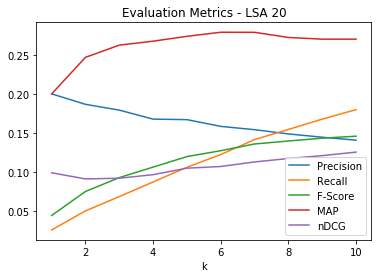

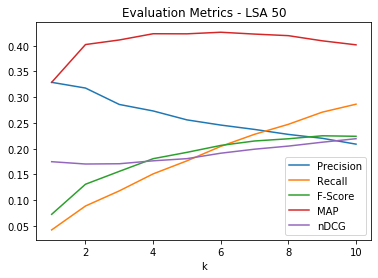

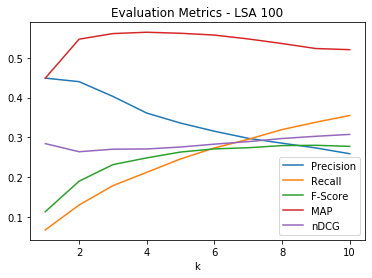

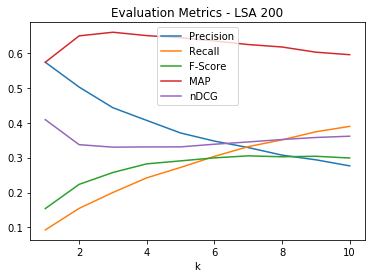

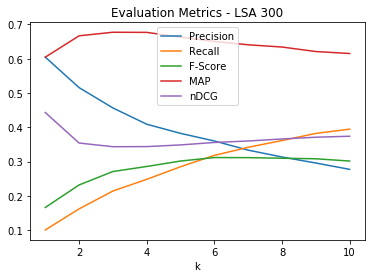

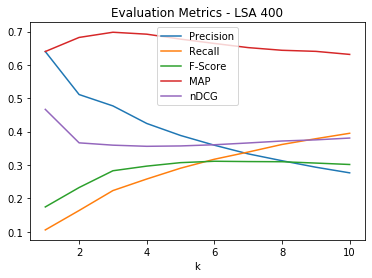

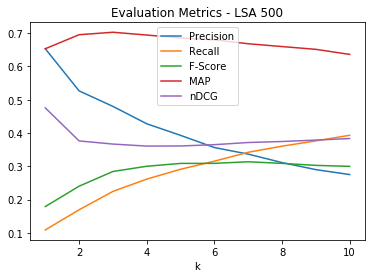

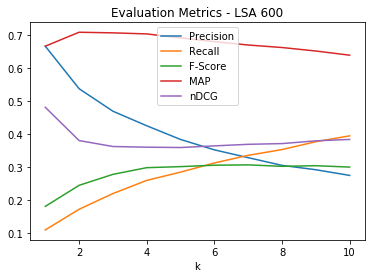

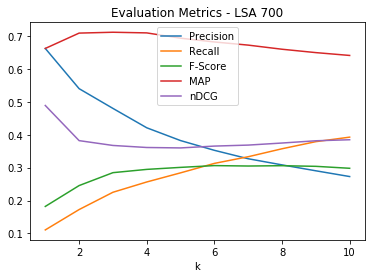

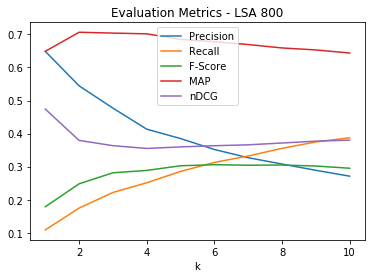

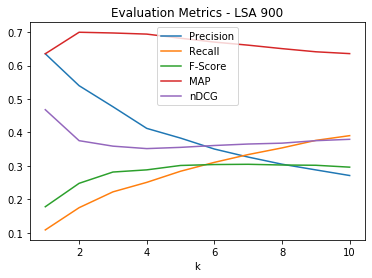

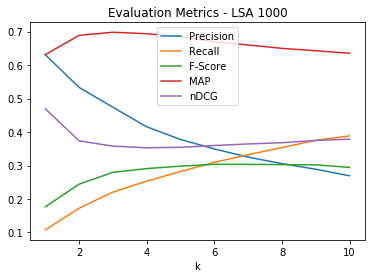

In [44]:
components_used = [20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# components_used = [1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
# components_used = [1,10]
for n_comp in components_used:
    svd = TruncatedSVD(n_components=n_comp)
    svd.fit(tf_idf_docs.T)
    tr_docs = svd.transform(tf_idf_docs.T).T
    # tr_docs.shape
    qr_tr = svd.transform(vec_rep_queries.T).T
    # qr_tr.shape
    cosine_sim = np.matmul(tr_docs.T, qr_tr )
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
    print("\nLSA with "+str(n_comp)+" in progress\n")
    Evaluation_metrics(doc_IDs_ordered, query_ids, qrels, n_comp, op_folder='./tf_idf_matrix/')
    
    

### Clustering documents to reduce search time

In [118]:
km = KMeans(n_clusters= 3, random_state=0)
km.fit(tf_idf_docs.T)
km.cluster_centers_.shape

(3, 8061)

In [119]:
cluster_doc_ids = {}
for i in range(1400):
    try :
        cluster_doc_ids[km.labels_[i]] += [i]
    except :
        cluster_doc_ids[km.labels_[i]] = [i]

In [120]:
# cluster_query = np.matmul(vec_rep_queries.T, km.cluster_centers_.T)
# cluster_query = np.argmax(cluster_query, axis = 1)
# cluster_query.shape

# normal method of retrieval
tic = time.time()
cosine_sim = []
for i in range(1400):
    cosine_sim.append(np.matmul(tf_idf_docs[:,i].T, vec_rep_queries[:,0]))
cosine_sim = np.array(cosine_sim)
doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
print(len(doc_IDs_ordered))
toc = time.time()
print("without clustering, Retrieval time : "+str(toc-tic))

# clustering method
tic = time.time()
cluster = np.argmax(np.matmul(vec_rep_queries[:,0], km.cluster_centers_.T))
cluster_docs = tf_idf_docs[:, cluster_doc_ids[cluster]]
# cosine_sim = np.matmul(tf_idf_docs[:, cluster_doc_ids[cluster]].T,vec_rep_queries[:,0])
cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries[:,0])
doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
print(len(doc_IDs_ordered_clus))
doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clus]+1
toc = time.time()
print("clustering method, Retrieval time : "+str(toc-tic))


1400
without clustering, Retrieval time : 0.11169314384460449
339
clustering method, Retrieval time : 0.03991985321044922


In [121]:
## checking for the compensation made
doc_IDs_ordered = []
for qry_idx in range(225):
    cluster = np.argmax(np.matmul(vec_rep_queries[:,qry_idx], km.cluster_centers_.T))
    cluster_docs = tf_idf_docs[:, cluster_doc_ids[cluster]]
    # cosine_sim = np.matmul(tf_idf_docs[:, cluster_doc_ids[cluster]].T,vec_rep_queries[:,0])
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries[:,qry_idx])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    # print(len(doc_IDs_ordered_clus))
    doc_IDs_ordered.append((np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clus]+1).tolist())
    


In [122]:
Evaluation_metrics(doc_IDs_ordered, query_ids, qrels,n_comp = 0,save_results=0)

Precision, Recall and F-score @ 1 : 0.5155555555555555, 0.08320582257248918, 0.13824974144141491
MAP, nDCG @ 1 : 0.5155555555555555, 0.37037037037037024
Precision, Recall and F-score @ 2 : 0.43333333333333335, 0.13237784723398752, 0.19160162411341705
MAP, nDCG @ 2 : 0.5644444444444444, 0.29137936196428876
Precision, Recall and F-score @ 3 : 0.3733333333333335, 0.1678073093248532, 0.2165443416468593
MAP, nDCG @ 3 : 0.5696296296296295, 0.2732384129456392
Precision, Recall and F-score @ 4 : 0.3244444444444444, 0.19224661465889528, 0.22514948575973204
MAP, nDCG @ 4 : 0.5641975308641974, 0.2665287270118653
Precision, Recall and F-score @ 5 : 0.29688888888888915, 0.21485553915287725, 0.23213549473514458
MAP, nDCG @ 5 : 0.5595802469135803, 0.2684600497591767
Precision, Recall and F-score @ 6 : 0.27407407407407414, 0.23487394667128483, 0.23548152912928877
MAP, nDCG @ 6 : 0.5511370370370371, 0.272678660167318
Precision, Recall and F-score @ 7 : 0.25142857142857156, 0.25116694769235604, 0.233878

### Observation
- Clustering reduced the retrieval time by 5

## Query Expansion -- distributional word similarity

In [125]:
from gensim.models import Word2Vec

In [128]:
All_sentences = []
for doc in Preprocessed_docs:
    for sent in doc:
        All_sentences.append(sent)
All_sentences

[['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream', '.'],
 ['experimental',
  'study',
  'wing',
  'propeller',
  'slipstream',
  'make',
  'order',
  'determine',
  'spanwise',
  'distribution',
  'lift',
  'increase',
  'due',
  'slipstream',
  'different',
  'angle',
  'attack',
  'wing',
  'different',
  'free',
  'stream',
  'slipstream',
  'velocity',
  'ratio',
  '.'],
 ['result',
  'intend',
  'part',
  'evaluation',
  'basis',
  'different',
  'theoretical',
  'treatment',
  'problem',
  '.'],
 ['comparative',
  'span',
  'load',
  'curve',
  ',',
  'together',
  'support',
  'evidence',
  ',',
  'show',
  'substantial',
  'part',
  'lift',
  'increment',
  'produce',
  'slipstream',
  'due',
  '/destalling/',
  'boundary-layer-control',
  'effect',
  '.'],
 ['integrate',
  'remain',
  'lift',
  'increment',
  ',',
  'subtract',
  'destalling',
  'lift',
  ',',
  'found',
  'agree',
  'well',
  'potential',
  'flow',
  'theory',
  '.'],
 ['empirical',
  'e

In [280]:
model = Word2Vec(min_count=1,
                window = 3,
                size = 500,
                sample = 6e-5)
t = time.time()
model.build_vocab(All_sentences, progress_per = 1000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


In [281]:
t = time.time()

model.train(All_sentences, total_examples=model.corpus_count, epochs=50, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 0.1 mins


In [282]:
res = np.array(model.wv.most_similar(positive=["good"]))[:,0].tolist()
res

['agreement',
 'result',
 'experimental',
 'comparison',
 'theoretical',
 'data',
 'compare',
 'satisfactory',
 'prediction',
 'reasonably']

In [283]:
def query_expansion(query, wv_model,v=1):
    """
    query : query to be expanded (a list of lists, where each sublist is a sentence)
    wv_model : word2vec trained model
    v : top v similar words taken into consideration
    """
    expanded_query = query.copy()
    for sent in query:
        
        for word in sent:
            
            try:
                expanded_query.append(np.array(wv_model.wv.most_similar(positive=[word],topn = v))[:,0].tolist())
            except:
                pass
    return expanded_query

In [284]:
# sample return of query_expansion result
query_expansion([["investigation","bad"]],model,v=1)

[['investigation', 'bad'], ['make'], ['/equivalent']]

In [208]:
Preprocessed_queries[0]

[['similarity',
  'law',
  'must',
  'obeyed',
  'construct',
  'aeroelastic',
  'model',
  'heat',
  'high',
  'speed',
  'aircraft',
  '.']]

In [324]:
expanded_queries = []
for query in Preprocessed_queries:
    expanded_queries.append(query_expansion(query,model2, v=1))

In [325]:
vec_rep_exp_queries = TF_IDF(expanded_queries, query_ids, word_map, is_queries=True)

In [326]:
cosine_sim = np.matmul(tf_idf_docs.T, vec_rep_exp_queries )
doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()

In [327]:
Evaluation_metrics(doc_IDs_ordered, query_ids, qrels,n_comp = 0,save_results=0)

Precision, Recall and F-score @ 1 : 0.5688888888888889, 0.09684168008347573, 0.15870820228198967
MAP, nDCG @ 1 : 0.5688888888888889, 0.43259259259259253
Precision, Recall and F-score @ 2 : 0.4488888888888889, 0.14697573130258437, 0.2072926369482748
MAP, nDCG @ 2 : 0.6022222222222222, 0.33320738920741044
Precision, Recall and F-score @ 3 : 0.39407407407407413, 0.18768196107021773, 0.23572205787677245
MAP, nDCG @ 3 : 0.6259259259259259, 0.3192566249386525
Precision, Recall and F-score @ 4 : 0.35777777777777775, 0.21889976626315188, 0.2505928797829707
MAP, nDCG @ 4 : 0.6217283950617283, 0.31700049488089255
Precision, Recall and F-score @ 5 : 0.3342222222222225, 0.2530935267510301, 0.26504572638325036
MAP, nDCG @ 5 : 0.615814814814815, 0.32084445296351527
Precision, Recall and F-score @ 6 : 0.3118518518518516, 0.2811894036410246, 0.2718712925146969
MAP, nDCG @ 6 : 0.6047456790123459, 0.32763624303296285
Precision, Recall and F-score @ 7 : 0.29079365079365105, 0.30208772137267587, 0.2731852

In [139]:
from nltk.corpus import brown

In [140]:
brown.sents()

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [315]:
t = time.time()
model2 = Word2Vec(brown.sents(),min_count=1,
                window = 2,
                size = 200,
                sample = 6e-5)
# model.build_vocab(, progress_per = 10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.62 mins


In [316]:
t = time.time()

model2.train(All_sentences, total_examples=model.corpus_count, epochs=50, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 0.12 mins


In [328]:
res = np.array(model2.wv.most_similar(positive=["good"]))[:,0].tolist()
res

['fair',
 'kendrick',
 'excellent',
 'favorably',
 'computing-machine',
 'remarkably',
 'hollow-cylinder',
 'lees-hromas',
 "'qualitatively",
 'quite']

In [314]:
Sentences = All_sentences+brown.sents()
Sentences

[['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream', '.'], ['experimental', 'study', 'wing', 'propeller', 'slipstream', 'make', 'order', 'determine', 'spanwise', 'distribution', 'lift', 'increase', 'due', 'slipstream', 'different', 'angle', 'attack', 'wing', 'different', 'free', 'stream', 'slipstream', 'velocity', 'ratio', '.'], ...]

In [322]:
t = time.time()
model2 = Word2Vec(Sentences,min_count=1,
                window = 2,
                size = 300,
                sample = 6e-5)
# model.build_vocab(, progress_per = 10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.77 mins


In [323]:
t = time.time()

model2.train(All_sentences, total_examples=model.corpus_count, epochs=50, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 0.14 mins
